In [1]:
import pandas as pd
import numpy as np
import os
import sqlite3
import shutil
import datetime
import matplotlib.pyplot as plt
import tabulate
from IPython.display import HTML, display, Markdown
import csv
import unicodedata
import getopt
from ipywidgets import HBox, VBox, Layout

import ipywidgets as widgets
from ipywidgets import HBox, VBox, Layout
import graphviz
from GraphVizUtil import *
from GraphVizFormats import *
import warnings
warnings.filterwarnings('ignore')
import seaborn as sb
sb.set(style='darkgrid', font_scale=1.2)

def filter_descriptions(tech_comm_desc):
    try:
        tech_comm_desc = tech_comm_desc.values[0][0].replace('#', '').replace('"','').replace("\n",'').strip()
    except:
        tech_comm_desc = 'No description provided'
    return tech_comm_desc

def create_args_flowd(df_graph):
    nodes, tech, ltech, to_tech, from_tech = set(), set(), set(), set(), set()
    for ind,row in df_graph.iterrows():
        #descriptions:
        input_comm_des = filter_descriptions(pd.read_sql("SELECT comm_desc FROM commodities WHERE comm_name='" + row['input_comm'] + "'", con))
        output_comm_des = filter_descriptions(pd.read_sql("SELECT comm_desc FROM commodities WHERE comm_name='" + row['output_comm'] + "'", con))
        tech_des = filter_descriptions(pd.read_sql("SELECT tech_desc FROM technologies WHERE tech='" + row['tech'] + "'", con))

        if 'ethos' in row['input_comm']:
            ltech.add('"' + row['tech'] + '"' +  ' [tooltip = "' + tech_des + '"]')
        else :
            nodes.add('"' + row['input_comm'] + '"' +  ' [tooltip = "' + input_comm_des + '"]')
        nodes.add('"' + row['output_comm'] + '"' +  ' [tooltip = "' + output_comm_des + '"]')
        tech.add('"' + row['tech'] + '"' +  ' [tooltip = "' + tech_des + '"]')

        if row['input_comm'] != 'ethos':
            to_tech.add('"%s"' % row['input_comm'] + '\t->\t"%s"' % row['tech']) 
        from_tech.add('"%s"' % row['tech'] + '\t->\t"%s"' % row['output_comm'])
    args = dict(
    enodes = "".join('%s;\n\t\t' % x for x in nodes),
    tnodes = "".join('%s;\n\t\t' % x for x in tech),
    iedges = "".join('%s;\n\t\t' % x for x in to_tech),
    oedges = "".join('%s;\n\t\t' % x for x in from_tech),
    snodes = ";".join('%s' %x for x in ltech),
    )
    return args


def return_format_colors():
    colors = {}
    colors.update(getColorConfig(False))
    return colors, quick_run_dot_fmt

def return_flowd_table(final_dem, level=1):
    df = pd.read_sql("SELECT * FROM Efficiency", con)
    df_sel = df[df['output_comm']==final_dem]
    if len(df_sel)==0:
        df_sel = df[df['tech']==final_dem]
    inputs = df_sel['input_comm'].unique()
    iterval=0
    if level!=0:
        while len(inputs)>0:
            df_append = df[df['output_comm'].isin(inputs)]
            df_sel = pd.concat([df_sel, df_append])
            inputs = df_append['input_comm'].unique()
            iterval+=1
            if iterval>level-1:
                break
    df_graph = df_sel[['input_comm', 'tech', 'output_comm']].drop_duplicates()
    return df_graph

def return_flowd_table_fwds(final_dem):
    df = pd.read_sql("SELECT * FROM Efficiency", con)
    df_sel = df[df['output_comm']==final_dem]
    if len(df_sel)==0:
        df_sel = df[df['tech']==final_dem]
    inputs = df_sel['input_comm'].unique()
    outputs = df_sel['output_comm'].unique()

    iterval=0
    while len(inputs)>0:
        df_append = df[df['output_comm'].isin(inputs)]
        df_sel = pd.concat([df_sel, df_append])
        inputs = df_append['input_comm'].unique()
        iterval+=1
        if iterval>2:
            break
    iterval=0
    while len(outputs)>0:
        df_append = df[df['input_comm'].isin(outputs)]
        df_sel = pd.concat([df_sel, df_append])
        outputs = df_append['output_comm'].unique()
        iterval+=1
        if iterval>=0:
            break

    df_graph = df_sel[['input_comm', 'tech', 'output_comm']].drop_duplicates()
    return df_graph

con = sqlite3.connect(r'../US_9R_4D.sqlite') #change path to database
cur = con.cursor()   
con.text_factory = str 

def controls_rows(w):
    controls = HBox(w.children[:-1], layout = Layout(flex_flow='row wrap', width='max-content'))
    output = w.children[-1]
    display(VBox([controls, output],  layout = Layout(flex_flow='columns wrap', width='max-content', size=10)))
    

### Introduction

This notebook serves as the documentation for the Temoa input database used to produce the Open Energy Outlook (OEO) for the United States. [Temoa](https://temoacloud.com/) is an energy system optimization model, and thus performs capacity expansion of energy technologies across the whole energy system - fuel supply, electricity, transport, buildings and industry - over several future decades. This documentation is meant to provide a thorough explanation of the how technologies, commodities, and end-use demands are represented within the model, and also serves as a data repository and benchmark for other modeling efforts. Note that modeling such a complex system over several decades requires simplifications in order to make the model tractable.

When comparing the level of detail in our database with other modeling efforts, be sure to ask yourself the following questions:
1. What research questions is the model trying to answer?
2. Does the model cover the whole energy system or a particular sector?
3. Does the model perform capacity expansion over future years or does it focus on a single time period or operational issues given an existing capacity mix?

For the Open Energy Outlook, our [Roadmap](https://github.com/TemoaProject/oeo/blob/master/OEO_Roadmap.md) lays out the research questions we are planning to address. Addressing these questions requires consideration of three critical issues in the development of the model input database: spatial resolution, temporal resolution, and the level of technology detail, as explained below.

**Spatial resolution.** Regional differences in fuel supply, renewable resources, end-use demands, and existing capacities are an important determinant of how the future US energy system may evolve. While it would be useful to model all 50 states, particularly so we can capture state-level energy and climate policies, such a spatial resolution would be computational infeasible, given the other modeling requirements. Thus we need to aggregate states into regions. One of the critical challenges in choosing regions is the electric sector representation, where balancing authorities do not neatly follow state lines. Using [PowerGenome](https://github.com/PowerGenome/PowerGenome), we experimented with the aggregation of balancing authorities into regions that largely follow state boundaries, while still capturing the variations in supply and demand across the country. More details are given the electric power section of this document. Figure 1 shows the regions in the database, based on state-level aggregations, while Table 1 provides the definition of each region.

<a class="anchor" id="oeo_regions_map"></a>

<img src="documentation_images/states_to_temoa_state_groups.jpg" width="60%"/> 



**Figure 1.** The nine US regions in the OEO input database

In [2]:
df = pd.read_sql("SELECT * FROM regions", con)
headers=["Region","Description"]
display(Markdown('**Table 1.** Regions in the OEO input database'))
display(HTML(tabulate.tabulate(df.set_index('regions'), headers, stralign="left",tablefmt='html')))

**Table 1.** Regions in the OEO input database

Region,Description
CA,California
NW,Northwestern US
SW,Southwestern US
TX,Texas
N_CEN,North Central US
CEN,Central US
SE,Southeastern US
MID_AT,Mid Atlantic US
NE,Northeastern US


**Temporal resolution.** While the focus of energy systems modeling is on energy systems development over several decades, operational issues associated with electricity system dispatch are important to capture. The ability to adequately model electric power operation and dispatch is particularly important when considering systems that have a high penetration of renewable energy. Our base year is 2020, and the model has five-year time periods that extend to 2050. Each year within a given 5-year time period is assumed to be identical, and thus the model optimizes a representative year within each model time period. In order to capture operational issues and balance supply and demand at the sub-annual level, each representative year is broken down into a number of user-defined time slices. Those time slices can be defined as large blocks of time; for example, "summer - day", or at highly granular level; for example, hourly or sub-hourly resolution. Given our interest in modeling high renewables penetration, the brute force approach would suggest modeling every hour of the year for all future years in the projection, but such an approach is computationally infeasible. Thus we need a more clever approach. In this database, we use a "representative days" approach where several days, modeled at an hourly resolution, are used to represent an entire year's operations. These representative days are selected from annual datasets that include energy demands as well as wind and solar capacity factors using k-means clustering, as described in [Mallapragada et al, 2018](https://doi.org/10.1016/j.energy.2018.08.015) for the electricity sector, and implemented in [PowerGenome](https://github.com/PowerGenome/PowerGenome). Further details on the clustering approach are presented in the Electric Sector section.

Temoa is often solved in "perfect foresight" mode, where all decision variables corresponding to installed capacity and commodity flows are optimized simultaneously across all future time periods. To increase the number of representative days that can be modeled, we have developed a "myopic" mode for Temoa, whereby the user can solve a subset of future time periods at once. For example, it is possible to solve only the 2020-2025 time periods, retain the 2020 results, optimize the 2025-2030 results, retain the 2025 results, etc. Such a myopic approach conveys two advantages. First, by splitting one large capacity expansion problem into a series of smaller ones, the problem becomes more computationally tractable, and allows us to increase the number of representative days in the model. Second, a myopic approach is more realistic, as it provides limited look ahead rather than the "crystal ball" associated with perfect foresight runs.

The database used to produce the Open Energy Outlook has a time horizon that spans 2020 to 2050, with 5-year time periods. We are currently able to solve the full 9-region energy system database myopically with 24 representative days at hourly resolution. The current wall clock time for such a run is nearly 48 hours, given available compute resources. As the analysis progresses, we intend to use a version of the database with less representative days to perform sensitivity and uncertainty analysis, and a version with more representative days in a select number of scenarios to test system performance.


**Technology detail.** Energy system optimization models like Temoa represent technologies as a set of processes connected within a system by commodity flows. Technologies are represented by a set of engineering-economic parameters, including capital cost, fixed and variable operations and maintenance costs, conversion efficiencies, and emissions coefficients. The strength of models such as Temoa resides in their ability to capture these detailed cost and performance characteristics. While high granularity in technology representation can be an asset, unnecessary detail degrades computational performance and makes the model harder to interrogate. Across the sectors modeled in this project, we have applied expert judgement and articulated our assumptions regarding technology representation. The descriptions embedded in the following sections lay our our assumptions in detail, and are guided by the thinking laid out in our [Roadmap](https://github.com/TemoaProject/oeo/blob/master/OEO_Roadmap.md).

Within the input database, we model the following sectors: fuel supply, electricity, industry, buildings, and transportation. Because the database represents the whole energy system, energy commodities flow between technologies in different sectors, linking the entire system together in one large network. An example pathway associated with renewable electricity generation is shown in Figure 2.

**Figure 2.** An example pathway (of renewable electricity generation) in the modeled system

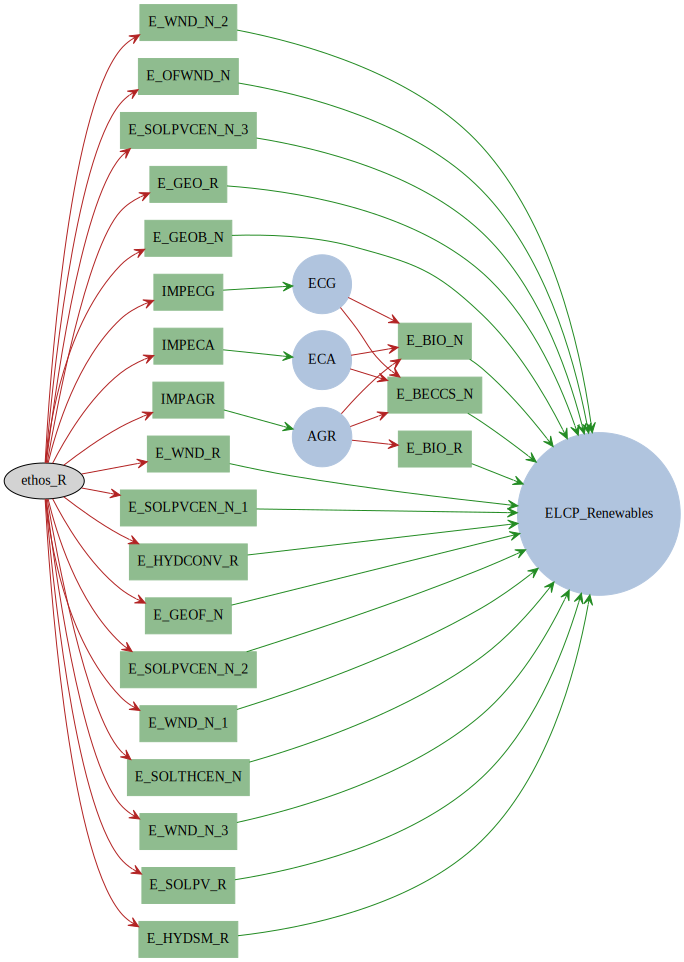

In [3]:
def refinery_network_diagram(con):
    final_dem = 'ELCP_Renewables'
    df_graph = return_flowd_table(final_dem,2)
    args = create_args_flowd(df_graph)
    colors, quick_run_dot_fmt = return_format_colors()
    args.update(colors)
    #o_str = 'rankdir = "LR" ;'
    #r_str = 'rankdir = "LR" ; \n\t size="8,8";'
    #quick_run_dot_fmt = quick_run_dot_fmt.replace(o_str, r_str)
    dot_graph = quick_run_dot_fmt % args
    display(Markdown('**Figure 2.** An example pathway (of renewable electricity generation) in the modeled system'))
    display(graphviz.Source(dot_graph))
    
refinery_network_diagram(con)


### Database Naming Conventions
This section describes the basic naming convention used for technologies and commodities in the database.

#### Technologies
The technology names in the database consists of several parts. These parts that are separated by an '_' and are meant to reveal information about a technology. Every technology name starts with a letter that identifies the sector to which the technology belongs. Table 2 shows the letters used to demonstrate different sectors.

**Table 2**. Letters and their corresponding sectors

| Letter | R | C | T | I | E
| :--- | :--- | :--- | :--- | :--- |  :--- |
| **Sector** | residential | commercial | transportation | industrial | electric

After the sector identifier, a shortened description of the technology is provided. For instance, “E_SOLPVCEN” represents utility-scale solar PV, and “C_SH_AHP_ELC” represents electric air-cooled heat pumps used for space heating in the commercial sector. As noted above, the “E” and “C” at the beginning of the names denote the sector to which the technology belongs. A full description of all the names are provided in the “technologies” table of the database. Technologies with an “EA” and “BLND” designation are used to facilitate emissions accounting and blending of separate fuels, respectively.

The last identifier indicates whether the technology exists in the base year or it is a future technology. Existing technologies have an “R” (i.e., "residual") while new technologies are shown by “N” (i.e., "new"). For example, “E_SOLPVCEN_R” and “C_SH_AHP_ELC_N” refer to existing (residual) utility-scale PV plants and new electric air-cooled heat pumps used for space heating in the commercial sector, respectively.

#### Energy Commodities
Table 3 defines the main energy carriers used in the database.

**Table 3.** Fuels names in the database

|Name in the database | Fuel|
| :--- | :--- |
|NGA			|	Natural gas |
|COAL			|	Lignite coal|
|COAB			|	Bituminous coal|
|COAS			|	Subbituminous coal|
|URN			|	Uranium|
|ELCP			|	Electricity from fossil-based plants|
|ELCP_Renewables|	Electricity from renewable plants|
|ELC			|	Electricity at the point of consumption|
|STV			|	Corn stover|
|AGR			|	Agricultural residue|
|ECG			|	Energy crop – grass|
|ECW			|	Energy crop – woody|
|FSR			|	Forest residue|
|UWW			|	Urban wood waster|
|SOY			|	Soy|
|DISTOIL		|	Distillate oil|
|KER			|	Kerosene|
|RFO			|	Residual fuel oil|
|LPG			|	Liquified petroleum gas|
|CNG			|	Compressed natural gas|
|GAS			|	Gasoline|
|DSL			|	Diesel|
|E10			|	Blend of 10% ethanol and 90% gasoline|
|E85			|	Blend of 85% ethanol and 15% gasoline|
|B20			|	Blend of 20% bio-diesel and 80% diesel|
|JTF			|	Jet fuel|
|BIOJTF			|	Bio jet fuel|
|ETH_CORN		|	Corn ethanol|
|ETH_CEL		|	Cellulosic ethanol|
|MEOH			|	Methanol|
|BIODSL			|	Biodiesel|
|H2				|	Hydrogen|
|SNG			|	Synthetic gas|


### Technology/commodity description lookup tool <a class="anchor" id="description_look_up"></a>
Use the tool below to search for any key words that may describe a technology or commodity of interest (e.g. heating, cooling). The tool provides a list of all the technologies or commodities in the database that may be relevant to the query.


In [4]:
w = widgets.Text(value='space heating demand')
display(w)
def f(w):
    if len(w)>0:
        df1 = pd.read_sql("SELECT * FROM commodities WHERE comm_desc LIKE '%" + w + "%'", con)
        df1['desc'] = df1['comm_desc'].str.replace('#','').str.strip()
        df1['comm_tech'] = df1['comm_name']
        df1['type'] = 'commodity'

        df2 = pd.read_sql("SELECT * FROM technologies WHERE tech_desc LIKE '%" + w + "%'", con)
        df2['desc'] = df2['tech_desc'].str.replace('#','').str.strip()
        df2['comm_tech'] = df2['tech']
        df2['type'] = 'technology'


        df = pd.concat([df1[['comm_tech','type','desc']], df2[['comm_tech','type','desc']]])
        
        if len(df)>0:
            display(HTML(tabulate.tabulate(df.set_index('comm_tech'),['technology/commodity','type','description'],stralign='left',tablefmt='html')))
        else:
            print('')
    else:
        print('')
            


out = widgets.interactive_output(f, {'w': w})
display(out)

Text(value='space heating demand')

Output()

### Network diagram lookup tool  <a class="anchor" id="network_look_up"></a>
Use the [description lookup tool](#description_look_up) above to identify specific commodity or technology names. Type the name in the box below to generate a corresponding network diagram for that commodity or technology. The slider can be used to view different upstream levels of the network diagram.

In [5]:
w = widgets.Text(value='RSH')
display(w)
def f(w):
    if len(w)>0:
        
        df1 = pd.read_sql("SELECT comm_name, comm_desc FROM commodities WHERE comm_name='" + w + "'", con)
        df1['desc'] = df1['comm_desc'].str.replace('#','').str.strip()
        df1['comm_tech'] = df1['comm_name']
        df1['type'] = 'commodity'

        df2 = pd.read_sql("SELECT * FROM technologies WHERE tech='" + w + "'", con)
        df2['desc'] = df2['tech_desc'].str.replace('#','').str.strip()
        df2['comm_tech'] = df2['tech']
        df2['type'] = 'technology'

        df = pd.concat([df1[['comm_tech','type','desc']], df2[['comm_tech','type','desc']]])

    
        if len(df)>0:
            def show_desc(level):
                display(Markdown(df['desc'][0]))
                final_dem = df['comm_tech'][0]
                df_graph = return_flowd_table(final_dem,level)
                args = create_args_flowd(df_graph)
                colors, quick_run_dot_fmt = return_format_colors()
                args.update(colors)
                #o_str = 'rankdir = "LR" ;'
                #r_str = 'rankdir = "LR" ; \n\t size="8,8";'
                #quick_run_dot_fmt = quick_run_dot_fmt.replace(o_str, r_str)
                dot_graph = quick_run_dot_fmt % args
                display(graphviz.Source(dot_graph))
            w2 = widgets.IntSlider(value=1,min=0,max=10,step=1,description='Level:',disabled=False,continuous_update=True,orientation='horizontal',readout=True,readout_format='d')
            w = widgets.interactive(show_desc, level=w2)
            controls_rows(w)
        else:
            print('')

    else:
        print('')
            


out = widgets.interactive_output(f, {'w': w})
display(out)

Text(value='RSH')

Output()

### Technology/commodity look-up tool
Use the tool below to retrieve the description for any technology or commodity within the database. Type the commodity or technology name in the box below to view the description. Note that names are case sensitive.

In [6]:
w = widgets.Text(value='ELC')
display(w)
def f(w):
    df = pd.read_sql("SELECT * FROM commodities WHERE comm_name='" + w + "'", con)
    if len(df)==0:
        df = pd.read_sql("SELECT * FROM technologies WHERE tech='" + w + "'", con)

    if len(df)>0:
        try:
            display(Markdown((df['comm_desc'].values[0].replace('#', '').strip())))
        except:
            display(Markdown(df['tech_desc'].values[0].replace('#', '').strip()))
    else:
        print('')


out = widgets.interactive_output(f, {'w': w})
display(out)


Text(value='ELC')

Output()